In [1]:
# Import required libraries
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchaudio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import glob
from tqdm import tqdm

In [2]:
# Define CNN Model
class EmotionCNN(nn.Module):
    def __init__(self, num_classes=8):
        super(EmotionCNN, self).__init__()
        
        # Feature extraction layers
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            
            # Block 1
            nn.Conv2d(64, 64, kernel_size=7, padding=3, groups=64),  # Depthwise
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=1),  # Pointwise
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 2
            nn.Conv2d(128, 128, kernel_size=7, padding=3, groups=128),  # Depthwise
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=1),  # Pointwise
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 3
            nn.Conv2d(256, 256, kernel_size=7, padding=3, groups=256),  # Depthwise
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 512, kernel_size=1),  # Pointwise
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1)  # Global average pooling to 1x1
        )
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),  # Explicitly flatten to ensure proper shape
            nn.Dropout(0.5),
            nn.Linear(512, 256),  # Input is 512 from the last conv layer
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [3]:
# Define the test dataset class
class RavdessTestDataset(Dataset):
    def __init__(self, test_path):
        self.test_path = test_path
        self.file_paths = []
        self.labels = []  
        
        # Map emotion label from filename to emotion category
        self.emotion_map = {
            '01': 0,  # neutral
            '02': 1,  # calm
            '03': 2,  # happy
            '04': 3,  # sad
            '05': 4,  # angry
            '06': 5,  # fearful
            '07': 6,  # disgust
            '08': 7   # surprised
        }
        
        # Emotion names for reporting
        self.emotion_names = ["neutral", "calm", "happy", "sad", "angry", "fearful", "disgust", "surprised"]
        
        # Search all test actor folders (Actor_20 to Actor_24)
        test_actor_dirs = glob.glob(os.path.join(test_path, "Actor_*"))
        
        print(f"Found {len(test_actor_dirs)} test actor directories")
        
        # Process each actor directory
        for actor_dir in test_actor_dirs:
            # Get all audio files in this actor folder
            audio_files = glob.glob(os.path.join(actor_dir, "*.wav"))
            
            for audio_file in audio_files:
                filename = os.path.basename(audio_file)
                # Extract emotion from filename (3rd part in RAVDESS convention)
                parts = filename.split('-')
                if len(parts) >= 3:
                    emotion_code = parts[2]
                    if emotion_code in self.emotion_map:
                        self.file_paths.append(audio_file)
                        self.labels.append(self.emotion_map[emotion_code])
        
        print(f"Found {len(self.file_paths)} test audio files with valid emotions")
        
        # Print emotion distribution in test set
        self.emotion_counts = {}
        for label in self.labels:
            if label not in self.emotion_counts:
                self.emotion_counts[label] = 0
            self.emotion_counts[label] += 1
        
        print("Test set emotion distribution:")
        for emotion, count in sorted(self.emotion_counts.items()):
            emotion_name = self.emotion_names[emotion]
            print(f"  - {emotion_name} (class {emotion}): {count} files")
        
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        audio_path = self.file_paths[idx]
        label = self.labels[idx]
        
        # Load audio
        waveform, sample_rate = torchaudio.load(audio_path)
        
        # Convert to mono if stereo
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)
        
        # Create mel spectrogram
        mel_transform = torchaudio.transforms.MelSpectrogram(
            sample_rate=sample_rate,
            n_fft=1024,
            hop_length=512,
            n_mels=64
        )
        mel_spectrogram = mel_transform(waveform)
        
        # Convert to decibels
        mel_spectrogram = torchaudio.transforms.AmplitudeToDB()(mel_spectrogram)
        
        # Resize spectrogram to fixed dimensions (64x400)
        fixed_width = 400  # Match the width used in training
        if mel_spectrogram.shape[2] > fixed_width:
            mel_spectrogram = mel_spectrogram[:, :, :fixed_width]  # Crop if too long
        else:
            # Pad if too short
            padding = torch.zeros(1, 64, fixed_width - mel_spectrogram.shape[2])
            mel_spectrogram = torch.cat((mel_spectrogram, padding), dim=2)
        
        # Ensure 3 channels for CNN (repeat the spectrogram 3 times)
        mel_spectrogram = mel_spectrogram.repeat(3, 1, 1)
        
        return mel_spectrogram, label, audio_path  # Return file path for reference

In [4]:
# Padding collate function
def pad_collate(batch):
    """
    Pads spectrograms to have the same size before batching.
    """
    # Separate spectrograms, labels, and file paths
    spectrograms = [item[0] for item in batch]
    labels = [item[1] for item in batch]
    file_paths = [item[2] for item in batch]
    
    # Find max width
    max_width = max([spec.shape[2] for spec in spectrograms])
    
    # Pad spectrograms
    padded_spectrograms = []
    for spectrogram in spectrograms:
        current_width = spectrogram.shape[2]
        padding_needed = max_width - current_width
        
        if padding_needed > 0:
            padded = torch.nn.functional.pad(spectrogram, (0, padding_needed, 0, 0, 0, 0))
            padded_spectrograms.append(padded)
        else:
            padded_spectrograms.append(spectrogram)
    
    # Stack tensors
    padded_spectrograms = torch.stack(padded_spectrograms)
    labels = torch.tensor(labels)
    
    return padded_spectrograms, labels, file_paths

In [5]:
# Model summary function
def model_summary(model):
    print("\nModel Summary:")
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    # Print feature extractor layers
    print("\nFeature Extractor:")
    for idx, (name, module) in enumerate(model.features.named_children()):
        params = sum(p.numel() for p in module.parameters() if p.requires_grad)
        print(f"  Layer {idx}: {module.__class__.__name__:<15} Params: {params:,}")
    
    # Print classifier layers
    print("\nClassifier:")
    for idx, (name, module) in enumerate(model.classifier.named_children()):
        params = sum(p.numel() for p in module.parameters() if p.requires_grad)
        print(f"  Layer {idx}: {module.__class__.__name__:<15} Params: {params:,}")
    
    print(f"\nTotal parameters: {total_params:,}")
    print("_" * 50)

In [6]:
# Set paths and parameters
# Set paths
model_path = "/kaggle/input/model-emotion/best_emotion_model.pth"  # Change this to your model file path
test_data_path = "/kaggle/input/ravdess-speechemotionrecognition/SpeechEmotionRecognition/Test"   # Change this to path with Actor_20 to Actor_24 folders
batch_size = 32

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [7]:
# Load the model
# Load model
print(f"\nLoading model from: {model_path}")
model = EmotionCNN(num_classes=8).to(device)

if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path, map_location=device))
    print("Model loaded successfully!")
else:
    print(f"ERROR: Model file not found at {model_path}")

# Print model summary
model_summary(model)


Loading model from: /kaggle/input/model-emotion/best_emotion_model.pth
Model loaded successfully!

Model Summary:

Feature Extractor:
  Layer 0: Conv2d          Params: 9,472
  Layer 1: BatchNorm2d     Params: 128
  Layer 2: ReLU            Params: 0
  Layer 3: MaxPool2d       Params: 0
  Layer 4: Conv2d          Params: 3,200
  Layer 5: BatchNorm2d     Params: 128
  Layer 6: ReLU            Params: 0
  Layer 7: Conv2d          Params: 8,320
  Layer 8: BatchNorm2d     Params: 256
  Layer 9: ReLU            Params: 0
  Layer 10: MaxPool2d       Params: 0
  Layer 11: Conv2d          Params: 6,400
  Layer 12: BatchNorm2d     Params: 256
  Layer 13: ReLU            Params: 0
  Layer 14: Conv2d          Params: 33,024
  Layer 15: BatchNorm2d     Params: 512
  Layer 16: ReLU            Params: 0
  Layer 17: MaxPool2d       Params: 0
  Layer 18: Conv2d          Params: 12,800
  Layer 19: BatchNorm2d     Params: 512
  Layer 20: ReLU            Params: 0
  Layer 21: Conv2d          Params: 131

<ipython-input-7-3acafc265311>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


In [8]:
# Load test data
# Create test dataset and dataloader
print(f"\nLoading test data from: {test_data_path}")
test_dataset = RavdessTestDataset(test_data_path)
test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False,
    collate_fn=pad_collate
)


Loading test data from: /kaggle/input/ravdess-speechemotionrecognition/SpeechEmotionRecognition/Test
Found 5 test actor directories
Found 300 test audio files with valid emotions
Test set emotion distribution:
  - neutral (class 0): 20 files
  - calm (class 1): 40 files
  - happy (class 2): 40 files
  - sad (class 3): 40 files
  - angry (class 4): 40 files
  - fearful (class 5): 40 files
  - disgust (class 6): 40 files
  - surprised (class 7): 40 files


In [9]:
# Evaluate model on test set
# Evaluate model
model.eval()
all_preds = []
all_labels = []
all_file_paths = []

with torch.no_grad():
    for inputs, labels, file_paths in tqdm(test_loader, desc="Evaluating Test Set"):
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_file_paths.extend(file_paths)

# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average="weighted")
recall = recall_score(all_labels, all_preds, average="weighted")
f1 = f1_score(all_labels, all_preds, average="weighted")

# Create classification report
emotion_names = test_dataset.emotion_names
report = classification_report(all_labels, all_preds, target_names=emotion_names, output_dict=True)

# Create confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Create a DataFrame with predictions and file paths
results_df = pd.DataFrame({
    'File': [os.path.basename(fp) for fp in all_file_paths],
    'True_Label': [emotion_names[label] for label in all_labels],
    'Predicted_Label': [emotion_names[pred] for pred in all_preds],
    'Correct': [1 if pred == label else 0 for pred, label in zip(all_preds, all_labels)]
})

Evaluating Test Set: 100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


In [10]:
# Print evaluation metrics
# Print evaluation metrics
print(f"\nModel Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Print classification report
print("\nClassification Report:")
for class_name in emotion_names:
    if class_name in report:
        metrics = report[class_name]
        print(f"{class_name.ljust(10)}: Precision: {metrics['precision']:.4f}, "
              f"Recall: {metrics['recall']:.4f}, F1: {metrics['f1-score']:.4f}, "
              f"Support: {metrics['support']}")

# Print overall metrics
print(f"\nMacro Avg: Precision: {report['macro avg']['precision']:.4f}, "
      f"Recall: {report['macro avg']['recall']:.4f}, F1: {report['macro avg']['f1-score']:.4f}")
print(f"Weighted Avg: Precision: {report['weighted avg']['precision']:.4f}, "
      f"Recall: {report['weighted avg']['recall']:.4f}, F1: {report['weighted avg']['f1-score']:.4f}")


Model Evaluation Metrics:
Accuracy: 0.6233
Precision: 0.6118
Recall: 0.6233
F1 Score: 0.6111

Classification Report:
neutral   : Precision: 0.5000, Recall: 0.2500, F1: 0.3333, Support: 20
calm      : Precision: 0.6327, Recall: 0.7750, F1: 0.6966, Support: 40
happy     : Precision: 0.5429, Recall: 0.4750, F1: 0.5067, Support: 40
sad       : Precision: 0.4324, Recall: 0.4000, F1: 0.4156, Support: 40
angry     : Precision: 0.7609, Recall: 0.8750, F1: 0.8140, Support: 40
fearful   : Precision: 0.5641, Recall: 0.5500, F1: 0.5570, Support: 40
disgust   : Precision: 0.7000, Recall: 0.8750, F1: 0.7778, Support: 40
surprised : Precision: 0.7059, Recall: 0.6000, F1: 0.6486, Support: 40

Macro Avg: Precision: 0.6048, Recall: 0.6000, F1: 0.5937
Weighted Avg: Precision: 0.6118, Recall: 0.6233, F1: 0.6111


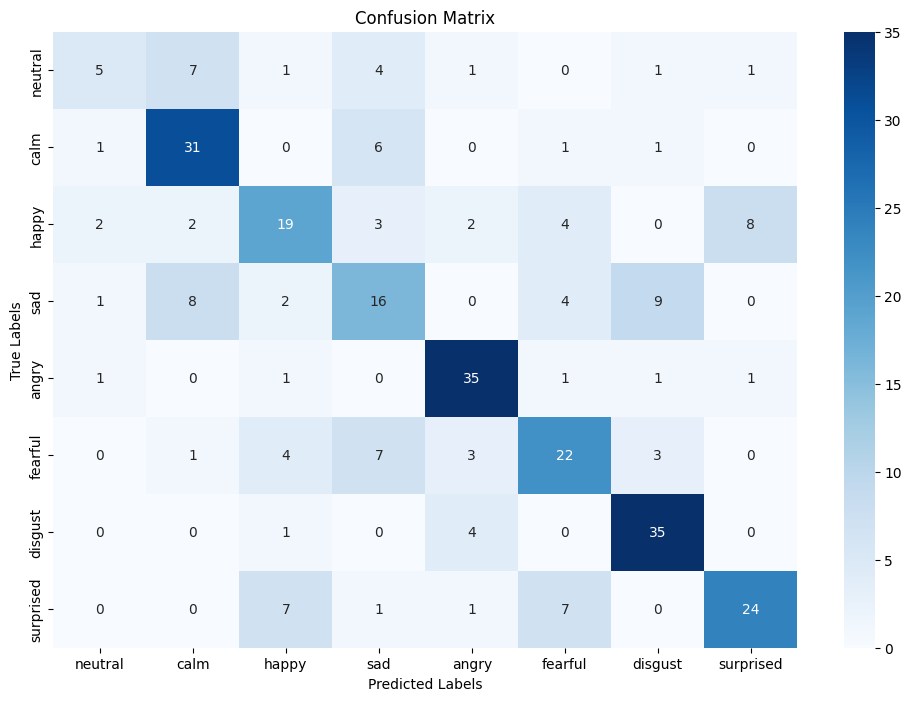

In [11]:
# Plot confusion matrix
# Plot confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=emotion_names, yticklabels=emotion_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.savefig('confusion_matrix.png')
plt.show()

In [12]:
# Calculate per-actor accuracy
# Calculate per-actor performance
actor_results = {}
for file_path, correct in zip(results_df['File'], results_df['Correct']):
    parts = file_path.split('-')
    if len(parts) >= 7:
        actor_id = parts[6]  # Actor ID is the 7th component (index 6)
        
        if actor_id not in actor_results:
            actor_results[actor_id] = {'total': 0, 'correct': 0}
        
        actor_results[actor_id]['total'] += 1
        actor_results[actor_id]['correct'] += correct

# Print per-actor accuracy
print("\nPer-Actor Accuracy:")
for actor_id, stats in sorted(actor_results.items()):
    accuracy = stats['correct'] / stats['total']
    print(f"Actor {actor_id}: {accuracy:.4f} ({stats['correct']}/{stats['total']})")


Per-Actor Accuracy:
Actor 20.wav: 0.5833 (35/60)
Actor 21.wav: 0.6167 (37/60)
Actor 22.wav: 0.5667 (34/60)
Actor 23.wav: 0.5333 (32/60)
Actor 24.wav: 0.8167 (49/60)


In [13]:
# Save results to CSV
# Save results to CSV
results_csv_path = "/kaggle/working/test_results.csv"
results_df.to_csv(results_csv_path, index=False)
print(f"\nDetailed results saved to {results_csv_path}")


Detailed results saved to /kaggle/working/test_results.csv
